## Currently Data

In [1]:
import covid_mx ## function and packages
# grid search model
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from numpy import array
# Python Data Analysis imports
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import pandas.plotting as pp

# Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# %matplotlib inline
# plt.style.use('fivethirtyeight')
from tabulate import tabulate

# statistics
from statsmodels.tsa.api import Holt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
## Load Data
df = covid_mx.load_data()
## specific column to analyze
dfObj = covid_mx.prepare_data(df,'Confirmed')

# Confirmed cases in México (Daily)

## CRISP-DM

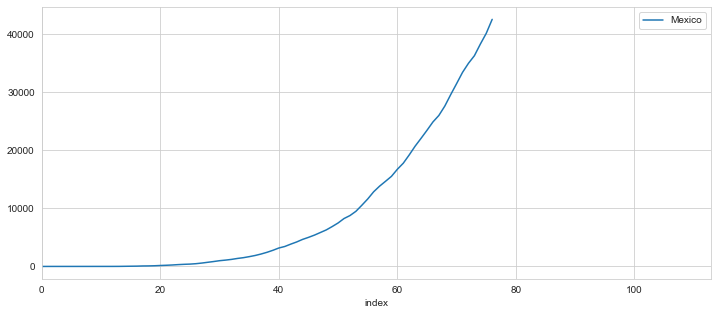

In [3]:
# Plotting Days in México "confirmed cases"
country = 'Mexico'
dfObj[country].plot(legend=True,figsize=(12,5))

## Model

In [4]:
## Subset Mexico and the world,  same pandemic days
df_mx = dfObj[country]
# Drop rows with missing Confirmed values
df_mx = df_mx.dropna()
# df_mx.index.max()


In [5]:
## Days
print(df_mx.index.max())

76


In [6]:
# https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/ 
data = pd.Series(df_mx).values
data = data.astype('double')
n_test = 5
cfg_list = covid_mx.exp_smoothing_configs()

In [7]:
scores = covid_mx.grid_search(data, cfg_list, n_test)

 > Model[[None, False, None, None, True, True]] 1379.426
 > Model[['add', False, None, None, True, True]] 485.867
 > Model[[None, False, None, None, True, False]] 1865.540
 > Model[[None, False, None, None, False, True]] 1385.920
 > Model[[None, False, None, None, False, False]] 1865.540
 > Model[['add', False, None, None, True, False]] 483.175
 > Model[['add', False, None, None, False, True]] 444.395
 > Model[['add', False, None, None, False, False]] 449.568
 > Model[['add', True, None, None, False, True]] 444.387
 > Model[['add', True, None, None, False, False]] 449.567
 > Model[['add', True, None, None, True, True]] 538.593
 > Model[['add', True, None, None, True, False]] 611.672
 > Model[['mul', True, None, None, False, True]] 468.421
 > Model[['mul', True, None, None, False, False]] 474.932
 > Model[['mul', False, None, None, False, True]] 496.987
 > Model[['mul', False, None, None, False, False]] 497.734


In [8]:
for cfg, error in scores[:3]:
        print(cfg, error)

['add', True, None, None, False, True] 444.38723589084833
['add', False, None, None, False, True] 444.3951532273944
['add', True, None, None, False, False] 449.5672521538906


## Forecast

In [9]:
## Best
model = ExponentialSmoothing(pd.Series(data), 
                             trend='mul', damped=True, seasonal=None, seasonal_periods=None)
# fit model
model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)

In [10]:
print(model.summary().tables[1])

                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_slope             0.000000                 beta                 True
initial_level              0.6400619                  l.0                 True
initial_slope              1.2961739                  b.0                 True
damping_slope              0.9783322                  phi                 True
------------------------------------------------------------------------------


In [11]:
print(pd.Series(model.forecast(10)).round())

77    44644.0
78    46744.0
79    48894.0
80    51093.0
81    53340.0
82    55634.0
83    57974.0
84    60358.0
85    62785.0
86    65255.0
dtype: float64


Fg: Cases in Mexico Forecast.


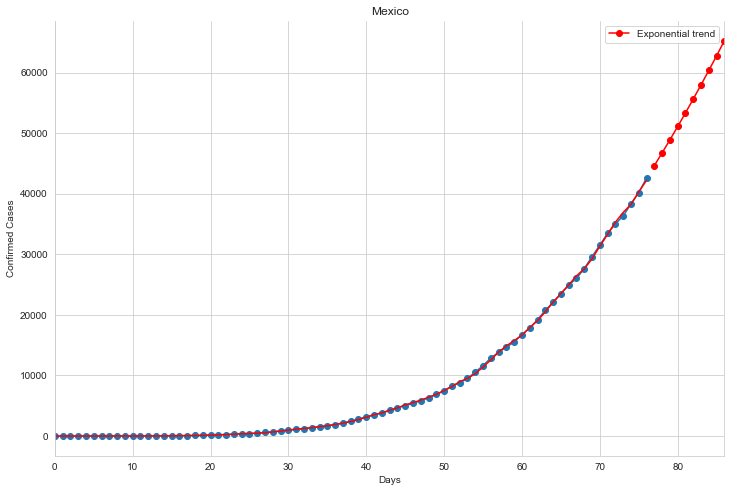

In [12]:
fcast = pd.Series(model.forecast(10)).rename("Exponential trend")
print("Fg: Cases in Mexico Forecast.")
ax = pd.Series(data).plot( marker="o", figsize=(12,8)) # color="blue",
pd.Series(model.fittedvalues).plot(ax=ax, color='red')
fcast.plot(ax=ax, color='red', marker="o", legend=True)
ax.set_title("Mexico")
ax.set_xlabel("Days")
ax.set_ylabel("Confirmed Cases")
ax.spines["top"].set_alpha(0)
plt.show()
